In [24]:
import sys
sys.path.append("/home/aj/robosys24/BlueberryJam/src")

from Classifier import *
from preprocess_img import *
import cv2 as cv
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt

In [25]:
# hsv_lo = (70, 0, 0) # overripe - belt conditions
# hsv_hi = (180, 67, 100)

# hsv_lo = (80, 53, 0) # ripe - belt conditions
# hsv_hi = (180, 125, 105)

# hsv_lo = (0, 118, 0) # red/green - belt conditions
# hsv_hi = (180, 255, 150)
masks = [[(80, 53, 0), (180, 125, 105)],[(70, 0, 0), (180, 67, 100)],[(0, 118, 0), (180, 255, 150)]]
# [better overripe, ripe, all 3]

In [26]:
def apply_background(mask:list, path:str = None,frame = None):

    if path is not None:
        # load image
        #/home/blueberryjam/BlueberryJam/img/test_set/ripe/R_06.14.jpg
        full_path = '/home/aj/robosys24/BlueberryJam/' + path
        img = cv.imread(full_path)
    elif frame is not None:
        img = frame #convert_pc2_cv2img(frame)
    else:
        # print("ERROR: no path or frame provided to preprocessor")
        raise RuntimeError

    if img is None:
        raise FileNotFoundError(f"Could not load image at{full_path}")

    # print("processing got here 1")

# convert to viewable and usable color spaces
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# normalize colors (may be useless)
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    pixel_colors = img_hsv.reshape((np.shape(img_hsv)[0]*np.shape(img_hsv)[1], 3))
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
# define color mask
    hsv_lo = mask[0]
    hsv_hi = mask[1]
# apply color mask to image
    mask_hsv = cv.inRange(img_hsv, hsv_lo, hsv_hi)

    return mask_hsv,img_rgb

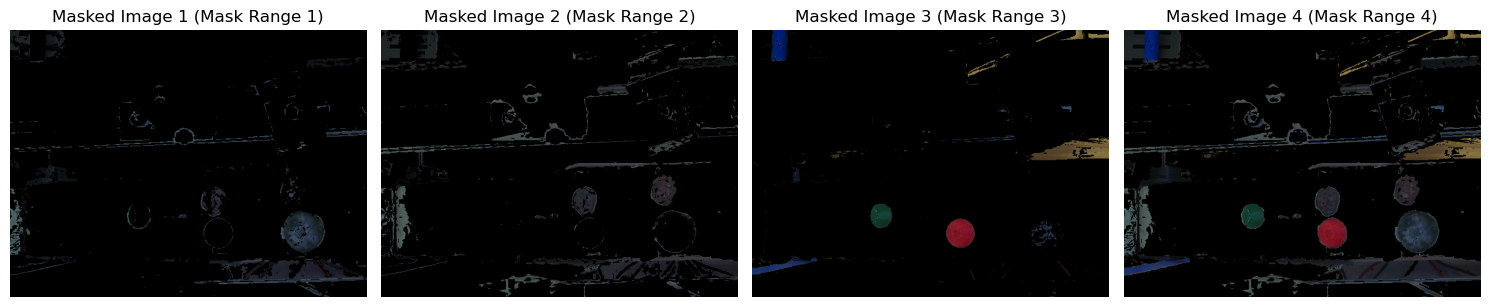

In [28]:

# Load the image
path = 'img/image_20241201_182123.jpg'


# img_orig = cv.imread('/home/aj/robosys24/BlueberryJam/img/test_set/overripe/ORN_03.jpg')
# img_orig = cv.cvtColor(img_orig, cv.COLOR_BGR2RGB)

def apply_multi_bg(masks: list, path: str = None) -> list:
    # Initialize an empty list to store the masked images
    masked_images = []

    # Loop through each range of low and high values, and use the apply_background function
    for i, (lower, upper) in enumerate(masks):
        # Call the apply_background function to create the mask for each range
        mask, img_rgb = apply_background([lower, upper], path=path)

        # Apply the mask using cv2.bitwise_and
        masked_image = cv.bitwise_and(img_rgb, img_rgb, mask=mask)

        # Append the masked image to the list
        masked_images.append(masked_image)

        # Initialize the combined_mask with the first mask on the first iteration
        if i == 0:
            combined_mask = np.zeros_like(mask)  # Initialize the combined mask with the first mask's shape

        # Combine all the masks using bitwise OR
        combined_mask = cv.bitwise_or(combined_mask, mask)

    # Apply the combined mask to the image
    combined_image = cv.bitwise_and(img_rgb, img_rgb, mask=combined_mask)

    # Append the combined image to the list
    masked_images.append(combined_image)

    return masked_images


masked_images_rgb = apply_multi_bg(masks, path)
# Display the images using matplotlib
fig, axs = plt.subplots(1, 4, figsize=(15, 10))


# Masked images from the loop
for i, masked_image_rgb in enumerate(masked_images_rgb):
    axs[i].imshow(masked_image_rgb)
    axs[i].set_title(f'Masked Image {i+1} (Mask Range {i+1})')
    axs[i].axis('off')

plt.tight_layout()
plt.show()
